In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

In [3]:
df = pd.read_csv(r"C:\Users\ACER\Desktop\Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.shape

(10000, 14)

In [6]:
for col in df.columns:
    data = df.copy()
    print("No.of unique values of {} is {}".format(col,len(data[col].unique())))
    

No.of unique values of RowNumber is 10000
No.of unique values of CustomerId is 10000
No.of unique values of Surname is 2932
No.of unique values of CreditScore is 460
No.of unique values of Geography is 3
No.of unique values of Gender is 2
No.of unique values of Age is 70
No.of unique values of Tenure is 11
No.of unique values of Balance is 6382
No.of unique values of NumOfProducts is 4
No.of unique values of HasCrCard is 2
No.of unique values of IsActiveMember is 2
No.of unique values of EstimatedSalary is 9999
No.of unique values of Exited is 2


In [7]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = "columns")

<AxesSubplot:>

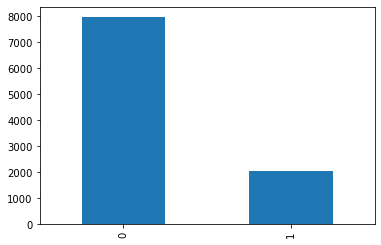

In [8]:
count_classes = pd.value_counts(df["Exited"], sort = True)
count_classes.plot(kind = "bar")

In [9]:
df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [10]:
discrete_feature = [feature for feature in df.columns if len(df[feature].unique()) < 20]
print("Discrete Variables Count: ",len(discrete_feature))

Discrete Variables Count:  7


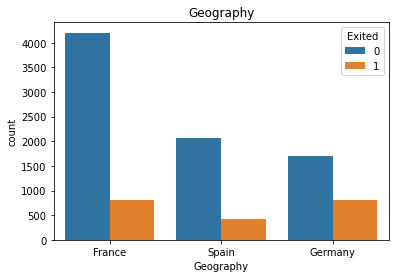

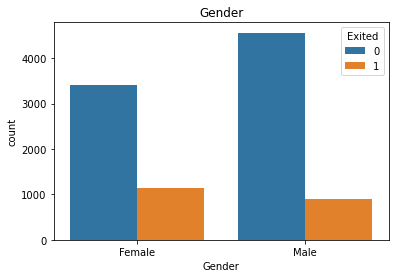

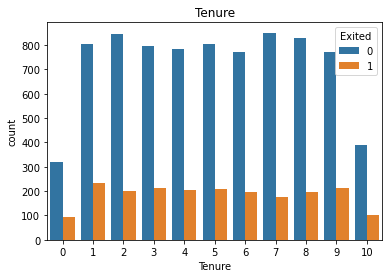

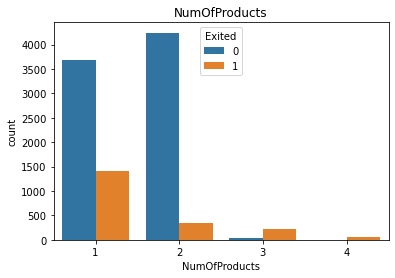

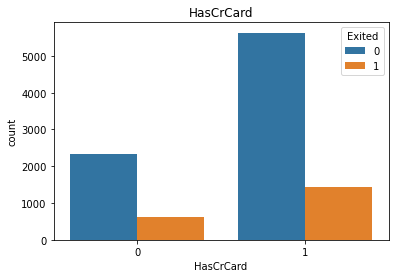

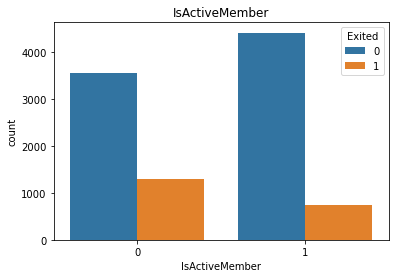

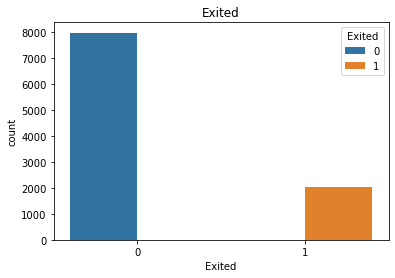

In [11]:
for feature in discrete_feature:
    data = df.copy()
    sns.countplot(x = feature, hue = "Exited", data = data);
    plt.title(feature)
    plt.show()

1. Most of the customers are from france, But most of the customers who have churned are from germany. so the proportion of churned customers is inversely realted to the population of customers
2. The female churned customers are high compared to the male customers
3. Interestingly, the majority of churned customers are using credit card 
4. Obviously the inactive members have greater churn
5. The Number of product

In [12]:
continuous_features = [feature for feature in df.columns if feature not in discrete_feature]
print(continuous_features)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


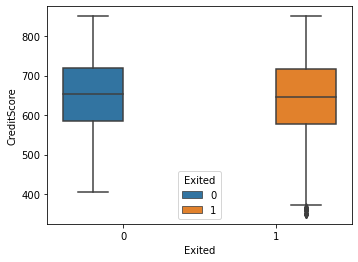

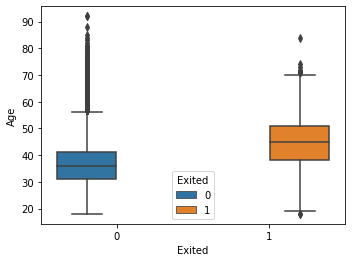

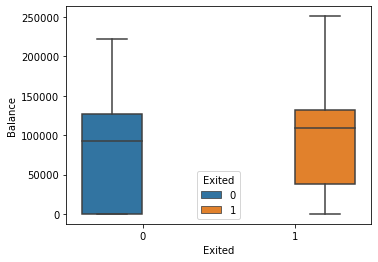

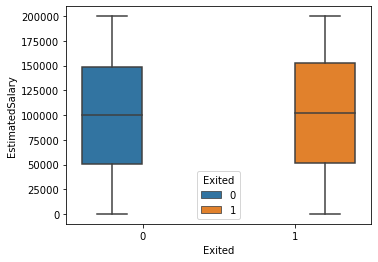

In [13]:
for feature in continuous_features:
    i = 0
    f = plt.figure(figsize = (12, 4))
    ax = f.add_subplot(121 + i)
    sns.boxplot(y = feature, x = "Exited", hue = "Exited", data = df,ax = ax)

1. There is no difference between CreditScore of churned customers and non-churned customers
2. Obviously the older customers are churning more than the younger ones
3. The salary is not effecting the customers for churning

<AxesSubplot:xlabel='Tenure', ylabel='Age'>

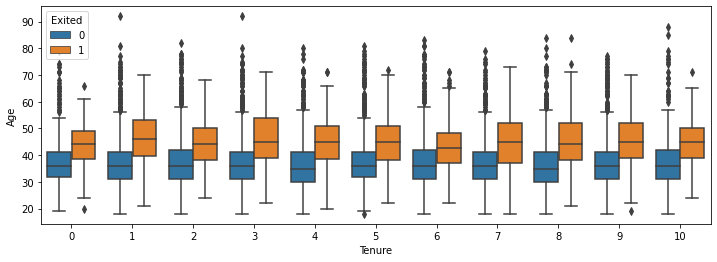

In [14]:
plt.figure(figsize = (12, 4))
sns.boxplot(y = "Age", x = "Tenure", hue = "Exited", data = df)

(-1.0, 5.0)

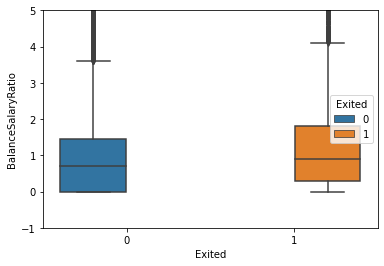

In [15]:
df["BalanceSalaryRatio"] = df.Balance/df.EstimatedSalary
sns.boxplot(y = "BalanceSalaryRatio", x = "Exited", hue = "Exited", data = df)
plt.ylim(-1, 5)

In [16]:
df.loc[df.HasCrCard == 0, "HasCrCard"] = -1
df.loc[df.IsActiveMember == 0, "IsActiveMember"] = -1
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000
1,608,Spain,Female,41,1,83807.86,1,-1,1,112542.58,0,0.744677
2,502,France,Female,42,8,159660.80,3,1,-1,113931.57,1,1.401375
3,699,France,Female,39,1,0.00,2,-1,-1,93826.63,0,0.000000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055


In [17]:
gender_dict = {"Male" : 1, "Female" : -1} 
for i in gender_dict:
    df["Gender"] = df["Gender"].replace(i, gender_dict[i])

In [18]:
geography_dict = {"Germany": -1, "Spain" : 1, "France" : 2}
for j in geography_dict:
    df["Geography"] = df["Geography"].replace(j, geography_dict[j])

In [19]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio
0,619,2,-1,42,2,0.00,1,1,1,101348.88,1,0.000000
1,608,1,-1,41,1,83807.86,1,-1,1,112542.58,0,0.744677
2,502,2,-1,42,8,159660.80,3,1,-1,113931.57,1,1.401375
3,699,2,-1,39,1,0.00,2,-1,-1,93826.63,0,0.000000
4,850,1,-1,43,2,125510.82,1,1,1,79084.10,0,1.587055


## OUTLIERS

In [20]:
#def lof_observation(df):
 #   numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  #  df_num_cols = df.select_dtypes(include = numerics)
   # df_outlier = df_num_cols.astype("float64")
#    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
  #  clf.fit_predict(df_outlier)
 #   df_scores = clf.negative_outlier_factor_
    #scores_df = 
    

In [21]:
def clear_outliers(df):
    
   # Q1 = df["Age"].quantile(0.25)
   # Q3 = df["Age"].quantile(0.75)
    #IQR = Q3 - Q1
    #lower = Q1 - 1.5 * IQR
    #upper = Q3 + 1.5 * IQR
    #df_outlier = df["Age"][(df["Age"] > upper)]
    #df["Age"][df_outlier.index] = upper
    
    
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    
    return df

data = df.copy()
data = clear_outliers(df)

<ipython-input-21-eac6f026e222>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CreditScore"][df_outlier.index] = lower


In [22]:
def outlier_process(df):
    df_outlier = clear_outliers(df = df)
    return df_outlier

In [23]:
def credit_score(row):
    
    if row >= 300 and row < 500:
        return 0 ## Very Poor
    elif row >= 500 and row < 601:
        return 1 ## Poor
    elif row >= 601 and row < 661:
        return 2 ## "FAIR"
    elif row >= 661 and row < 781:
        return 3 ## GOOD
    elif row >= 851:
        return 5 ## TOP
    elif row >= 781 and row < 851:
        return 4 ## EXcellent
    elif row < 300:
        return 6 ## Deep

In [24]:
df = df.copy()
df.CreditScore = df.CreditScore.apply(credit_score)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio
0,2,2,-1,42,2,0.00,1,1,1,101348.88,1,0.000000
1,2,1,-1,41,1,83807.86,1,-1,1,112542.58,0,0.744677
2,1,2,-1,42,8,159660.80,3,1,-1,113931.57,1,1.401375
3,3,2,-1,39,1,0.00,2,-1,-1,93826.63,0,0.000000
4,4,1,-1,43,2,125510.82,1,1,1,79084.10,0,1.587055
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,2,1,39,5,0.00,2,1,-1,96270.64,0,0.000000
9996,1,2,1,35,10,57369.61,1,1,1,101699.77,0,0.564108
9997,3,2,-1,36,7,0.00,1,-1,1,42085.58,1,0.000000
9998,3,-1,1,42,3,75075.31,2,1,-1,92888.52,1,0.808230


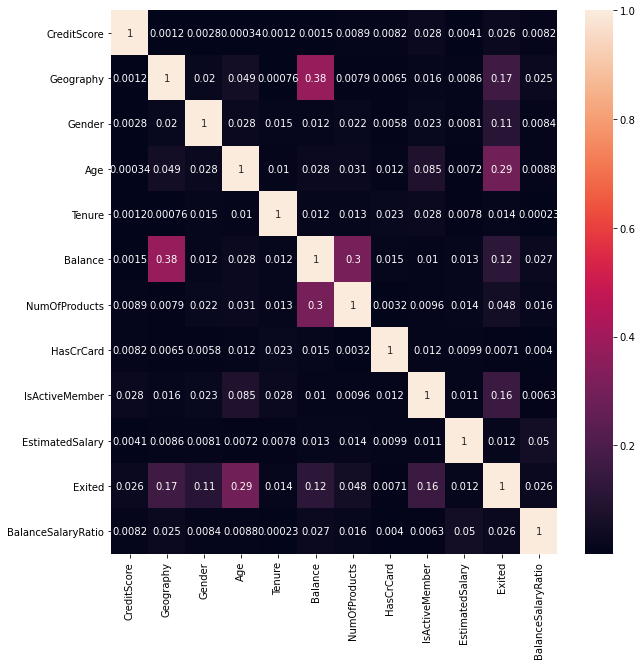

In [25]:
correlation = df.corr().abs()
plt.figure(figsize = (10, 10))
sns.heatmap(correlation, annot = True)
plt.show()

In [26]:
x = df.drop("Exited", axis = "columns")
y = df.Exited

## OVER SAMPLING

In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
x_res, y_res = sm.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size = 0.2, random_state = 7)

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [36]:
def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_auc_scores(y_actual, method, method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

## MOdel Tuning

## 

In [31]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)
lr_clf.score(x_test, y_test)

0.7423101067168864

## XGBoost Tuning

In [32]:
xgb_model = XGBClassifier(silent = 0, learning_rate = 0.23, max_delta_step = 5, objective = 'reg:logistic', n_estimators = 92, max_depth = 5, eval_metric = "logloss", gamma = 3, base_score = 0.5)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 2))
print("Accuracy score of tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

[17:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1580
           1       0.92      0.86      0.89      1606

    accuracy                           0.89      3186
   macro avg       0.89      0.89      0.89      3186
weighted avg       0.89      0.89      0.89      3186

Accuracy score of tuned XGBoost Regression:  0.891713747645951


## RandomForest Classifier

In [33]:
rnn_model = RandomForestClassifier(max_depth = 8, max_features = 6, min_samples_split = 6, n_estimators = 50)
rnn_model.fit(x_train, y_train)
y_pred = rnn_model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 2))
print("Accuracy score of Randomforest classifier: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1580
           1       0.92      0.84      0.88      1606

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186

Accuracy score of Randomforest classifier:  0.8797865662272442


## LightGBM Tuning

In [34]:
lgbm_model = LGBMClassifier(silent = 0, learning_rate = 0.09, max_delta_step = 2, n_estimators = 100, boosting_type = "gbdt", max_depth = 10, eval_metric = "logloss", gamma = 3, base_score = 0.5)
lgbm_model.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test)
print(classification_report(y_test, y_pred, digits = 2))
print("Accuracy score of LightGBM Tuning: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6357, number of negative: 6383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498980 -> initscore=-0.004082
[L

<AxesSubplot:>

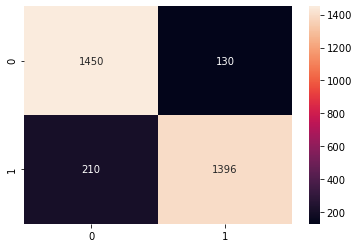

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = 'd')